In [1]:
from dotenv import load_dotenv
load_dotenv()
from langchain_openai import ChatOpenAI

from langgraph_supervisor import create_supervisor
from langgraph.prebuilt import create_react_agent
from langchain.agents import AgentExecutor
from typing_extensions import Annotated, TypedDict
from typing import Callable, Literal, Optional, Sequence, Type, TypeVar, Union, cast, List, Tuple, Any
from langchain_core.messages import AIMessage, BaseMessage, SystemMessage, ToolMessage
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph
from langgraph.prebuilt.tool_node import ToolNode, tools_condition
from langgraph.graph import MessagesState, START, END
from langgraph.types import Command
from langchain_core.messages import HumanMessage, AIMessage
from pydantic import BaseModel, Field
from langchain_core.runnables import RunnablePassthrough, RunnableLambda
from langchain_core.tools import tool
import json
from fpdf import FPDF
import os
import datetime

In [4]:
from sql_react_agent_llama import SQL_SUBAGENT, make_dataframe
from viz_agent_memory import VIZ_AGENT
from initiate_llm import gpt_llm, llama_llm

import pandas as pd

INSIDE NL2SQL TOOL
{'messages': [HumanMessage(content='Give me the names of 5 employees along with their full time or part time status', additional_kwargs={}, response_metadata={}, id='c447be4f-0770-4670-9c5a-fe21bd784a59'), ToolMessage(content='{"question": "Give me the names of 5 employees along with their full time or part time status", "query": "SELECT \\"first_name\\", \\"last_name\\", \\"full_time_or_part_time\\" FROM analytical_schema.dim_ukg_employee_job_history_details LIMIT 5"}', name='nl2sql_tool', id='44a35f5d-079a-463c-ad16-2a840ae91614', tool_call_id='tool_123'), ToolMessage(content='{"question": "Give me the names of 5 employees along with their full time or part time status", "query": "SELECT \\"first_name\\", \\"last_name\\", \\"full_time_or_part_time\\" FROM analytical_schema.dim_ukg_employee_job_history_details LIMIT 5", "result": "Error: (psycopg2.errors.UndefinedColumn) column \\"first_name\\" does not exist\\nLINE 1: SELECT \\"first_name\\", \\"last_name\\", \\"fu

##### Agent State and Setup

In [9]:
class AgentState(TypedDict):
    """The state of the agent."""
    messages: Annotated[Sequence[BaseMessage], add_messages]
    question: Annotated[str, Field(description="The user question")]
    sql_query: Annotated[str, Field(description="The SQL query generated by the agent")]
    results: List[List[Union[int, float, str, bool]]] = Field(..., description="The results returned by the SQL agent as a list of tuples.")
    df: pd.DataFrame = Field(..., description="The table returned by the make_table node as a pandas dataframe.")
    python_visualization_code: Annotated[str, Field(description="The Python code to visualize the results")]
    report_states: List[dict] = Field(..., description="The states of the report generation process")


##### SQL Sub-agent

In [6]:
# nl2sql_agent = create_agent(gpt_llm, [nl2sql_tool], "nl2sql")

def nl2sql_node(state: AgentState) -> Command[Literal["supervisor"]]:
    # last = state['messages'][-1]
    question = state["question"]
    try:
        question = json.loads(question)
        question = question["question"]
    except json.JSONDecodeError:
        pass        
    # print(last.content)
    result = SQL_SUBAGENT.invoke({"messages": [HumanMessage(content=question)]})
    return Command(
        update={
            "messages": [
                HumanMessage(content="sql_agent Result Message: GENERATED SQL AND RESULTS => " + result["messages"][-1].content, name="sql_agent")
            ],
            # "question": question,
            "sql_query": json.loads(result["messages"][-1].content)['query'],
            "results": json.loads(result["messages"][-1].content)['result'],
        },
        goto="supervisor",
    )

##### Make table node

In [11]:
def make_table_node(state: AgentState) -> Command[Literal["supervisor"]]:
    query = state["sql_query"]
    results = state["results"]
    df = make_dataframe(query, results)
    return Command(
        update={
            "messages": [
                HumanMessage(content=f"make_table Result Message: Here is the table I created from the results: {str(df)}", name="make_table")
            ],
            "df": df,
        },
        goto="supervisor",
    )

#### Vizualisation Node

In [10]:
def viz_node(state: AgentState) -> Command[Literal["supervisor"]]:
    question = state["question"]
    df = state["df"]
    results = state["results"]
    viz_agent_state = {
        "question": question,
        "df": df,
        "results": results,
        "messages": [],
        "error": ""
    }

    response = VIZ_AGENT.invoke(viz_agent_state)
    viz_code = response["generation"].imports + "\n" + response["generation"].code
    return Command(
        update={
            
            "messages": [
                HumanMessage(content=f"viz_agent Result Message: Here is the visualization code for plotting the data:\n {viz_code}", name="viz_agent")
            ],
            "python_visualization_code": viz_code,
        },
        goto="supervisor",
    )

#### Report Generation Node

In [31]:
def report_gen_node(state: AgentState) -> Command[Literal["supervisor"]]:
    states_list = state["report_states"]
    pdf = FPDF()
    cnt = 1
    
    for report_state in states_list:
        pdf.add_page()
        pdf.set_font("Arial", size=12)

        print("REPORT STATE: ", report_state)

        # Get user's question
        question = report_state.get("question", "")

        # Get visualization code
        viz_code = report_state.get("python_visualization_code", "")

        summary = report_state.get("summary", "")

        # Add title
        pdf.cell(200, 10, txt=f"Analysis #{cnt}", ln=True, align='C')
        pdf.ln(10)

        # Add user's question
        pdf.set_font("Arial", "B", 12)
        pdf.cell(0, 10, txt="Question:", ln=True)
        pdf.set_font("Arial", size=12)
        pdf.multi_cell(0, 10, txt=question)
        pdf.ln(5)

        # Generate and include visualization
        if viz_code:
            # Execute visualization code
            locals = {}
            exec(viz_code, {}, locals)
            fig = locals.get("fig")
            fig.show()
            if fig:
                timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
                plot_file = f"temp_pic_{timestamp}.png"
                png_bytes = fig.to_image(format="png", width=1200, height=800)
                with open(plot_file, "wb") as f:
                    f.write(png_bytes)
                
                pdf.set_font("Arial", "B", 12)
                pdf.cell(0, 10, txt="Visualization:", ln=True)
                pdf.image(plot_file, x=10, w=180)
                pdf.ln(5)
                # Clean up
                os.remove(plot_file)
        
        if summary:
            # Add summary
            pdf.set_font("Arial", "B", 12)
            pdf.cell(0, 10, txt="Summary:", ln=True)
            pdf.set_font("Arial", size=12)
            pdf.multi_cell(0, 10, txt=summary)
            pdf.ln(5)
        
        cnt += 1
    
    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    filename = f"report_{timestamp}.pdf"
    pdf.output(filename)

    return Command(
        update={
            
            "messages": [
                HumanMessage(content=f"report_agent Result Message: Report has been generated and saved as {filename}", name="report_agent")
            ],
            "report_states": []
        },
        goto="supervisor",
    )

#### Setting up Supervisor

In [24]:
# Define available agents
members = ["sql_agent", "make_table", "viz_agent", "report_agent"]
# Add FINISH as an option for task completion
options = members + ["FINISH"]


In [10]:
# supervisor_prompt = (
#     """
#     You are a supervisor agent named "SQLOrchestrator" tasked with managing the following workers (subagents/nodes): {members}.

# Your job is to orchestrate a multi-step pipeline to answer the user's question stored in `AgentState.question`. You will examine the current `AgentState` fields in this order and decide which worker to invoke next:

# 1. **SQL Generation & Execution**  
#    - If `AgentState.results` is empty (i.e. no SQL has been run), route to `sql_agent`.  
#    - The `sql_agent` should generate an `AgentState.sql_query` based on `AgentState.question`, execute it against the database, populate `AgentState.results` (a list of tuples), and append its result message to the conversation.

# 2. **Table Construction**  
#    - *Only* after the SQL has been run and populated the results, check if `AgentState.df` is empty. 
#    - If `AgentState.df` is empty (i.e. no DataFrame has been built), route to `make_table`.  
#    - The `make_table` node should take the raw `AgentState.results`, convert them into a pandas DataFrame `AgentState.df`, and append its result message to the conversation.

# 3. **Visualization Code**  
#    - *Only* after the SQL has run, populated the results and the dataframe is made, check if `AgentState.python_visualization_code` is empty.
#    - If `AgentState.python_visualization_code` is empty, route to `viz_agent`.  
#    - The `viz_agent` should inspect `AgentState.df` and generate the Python code needed to visualize the data, set it in `AgentState.python_visualization_code`, and append its result message to the conversation.

# 4. **Finish & Respond**  
#    - If all the necessary fields based on the intent of the question have been populated, route to `FINISH`.  
#    - When routing to `FINISH`, produce a natural-language final answer that directly addresses `AgentState.question` by summarizing the contents of `AgentState.df` and, if provided, reference the visualization code in `AgentState.python_visualization_code`. Include any key insights or metrics the user asked for.
#     """
# )

In [14]:
supervisor_memory_prompt = (
"""
You are a supervisor agent named "SQLOrchestrator" tasked with managing the following workers: {members}.

Your job is to orchestrate a multi-step pipeline to answer the user's latest query while handling follow-up questions based on the conversation history. You will examine the latest user message along with the conversation history to decide which worker to invoke next.

**Analyze the Latest Message and Conversation History**
- Use the conversation history and the latest message to determine the user's intent
- Either the user asks a question about the analysis/metrics of data as the very first message - in which case the pipeline starts from sql_agent and goes through all the steps including the table construction and visualization code generation.
- Or the user asks a followup question about previous results in the conversation history - and your task is to decide wether to start again from sql_agent or route to a different agent based on the user's intent:
- If the user asks to generate a report or save the results, route to `report_agent`.

   1. **SQL Generation & Execution**
      - *Routing logic based on user's intent*:
         - **New Query**: If the latest message is from the user and introduces a new question unrelated to the previous data (e.g., asking about a different table, metric, or dataset), route to `sql_agent`"
         - **Modify Query**: If the latest message is from the user and modifies the previous query but is still about getting some metrics/analysis from data (e.g., "Now group by department instead" or "Filter for 2023"), again reset and start from `sql_agent`.
      - The `sql_agent` will generate `sql_query`, execute it, populate `results`, and append its result message to the history.

   2. **Table Construction**
      - *Routing logic based on user's intent*:
         *ALWAYS* route to `make_table` *ONLY AFTER* `sql_agent` has appended its result message - which will be the last message in the conversation history.
      - The `make_table` worker will convert `results` into a dataframe and append its result message.
   
   3. **Visualization Code**
      - *Routing logic based on user's intent*:
         - Route to `viz_agent` *ONLY IF* one of these following conditions is met:
            - `make_table` has appended its result message - which will be the last message in the conversation history.
            - If the latest message is from the user and requests a different visualization of the same data (e.g., "Show this as a line graph" or "Make it a pie chart").
      - The `viz_agent` will generate Python code for visualization and append its result message.
   
   4. **Report Generation**
      - *Routing logic based on user's intent*:
         - *ONLY* if the latest message is from the user and requests to generate a report or save the results (e.g., "Generate a report" or "Save this as a PDF"), route to `report_agent`.
      - The `report_agent` will generate a report based on the conversation history and append its result message.
   
   5. **Finish & Respond**
      - If all necessary result messages in the pipeline have been appended (`sql_agent` to `make_table` and then to `viz_agent`, and if required - `report_agent`), and the latest message doesn’t require further processing:
         - The latest message is from the `viz_agent` itself, so no new action is needed, route to `FINISH`.
         - The latest message is from the `report_agent`, so no new action is needed, route to `FINISH`.
         - The latest message is from the user and asks only for a summary or clarification of the previous results and no intent to route to any other worker, route to `FINISH`.
      - When routing to `FINISH`, produce a natural-language final answer that:
         - Addresses the latest user message.
         - Summarizes the dataframe/results form the latest data used from the history (e.g., key metrics or trends).
         - Includes insights or answers specific to the user’s latest query.
         - *DO NOT* include the python code only natural language summary.

- When routing to `sql_agent`, or `viz_agent`, also generate a input `query` for the next worker based on the latest user message and the conversation history. This will help the next worker understand the context and intent of the user's request.
   - Specifically for `sql_agent` the query should be the latest user message.
   - Specifically for `viz_agent` the query should either be the latest user message if the user is asking for a different visualization of the same data as the latest message, or the same query used previously for `sql_agent` if the latest message is the result message from `make_table`.
"""
)

In [15]:
# Define router type for structured output
class Router(TypedDict):
    """Worker to route to next. If no workers needed, route to FINISH - AND give the final answer."""

    """The worker to route to next."""
    next: Literal["sql_agent", "make_table_node", "viz_agent", "report_agent", "FINISH"]
    """The query for the next worker. (if not FINISH)"""
    query: str
    """The final answer to the user's question if routing to FINISH."""
    final_answer: str

In [25]:
# Create supervisor node function
def supervisor_node(state: AgentState) -> Command[Literal["sql_agent", "make_table_node", "viz_agent", "report_agent", "__end__"]]:
    # messages = [
    #     {"role": "system", "content": supervisor_memory_prompt},
    # ] + state["messages"]
    print("\n\n========BACK TO SUPERVISOR========\n")

    state_info = {k: v for k, v in state.items() if k != 'messages'}

    messages = [
        {"role": "system", "content": supervisor_memory_prompt}
        # {"role": "user", "content": f"AgentState: {json.dumps(state_info, default=str)}"}
    ] + state["messages"]
    
    print("INVOKING WITH STATE INFO AND MESSAGES\n", state_info, "\n==\n", state["messages"])
    response = gpt_llm.with_structured_output(Router).invoke(messages)
    goto = response["next"]
    print(f"Next Worker: {goto}")

    if goto == "sql_agent":
        return Command(update={
            "question": response["query"],
            "sql_query": "",
            "results": "",
            "df": "",
            "python_visualization_code": ""
        } ,goto=goto)
    elif goto == "viz_agent":
        return Command(update={
            "question": response["query"],
            "python_visualization_code": ""
        }, goto=goto)

        
    elif goto == "FINISH":
        goto = END
        return Command(
            update={
                "messages": [
                    HumanMessage(content="FINAL ANSWER: " +response["final_answer"], name="supervisor")
                ],
            }
            ,goto=goto)
    
    return Command(goto=goto)

In [32]:
builder = StateGraph(AgentState)
builder.add_edge(START, "supervisor")
builder.add_node("supervisor", supervisor_node)
builder.add_node("sql_agent", nl2sql_node)
builder.add_node("make_table_node", make_table_node)
builder.add_node("viz_agent", viz_node)
builder.add_node("report_agent", report_gen_node)
graph = builder.compile()

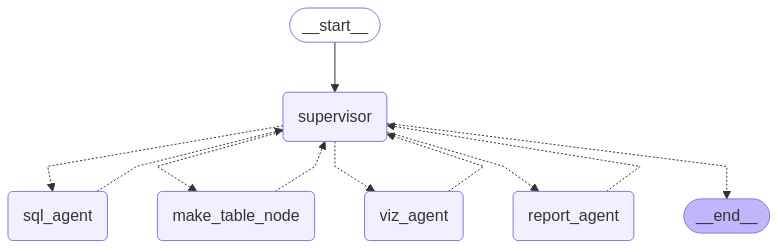

In [18]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
    # You can put your exception handling code here
    print(str(e))
    pass


In [33]:
initial_state = {
    "messages": [HumanMessage(content="Give me the number of employees present from each ethnicity")],
    "question": "",
    "sql_query": "",
    "results": "",
    "df": "",
    "python_visualization_code": "",
    "report_states": []
}

# result = graph.invoke(
#     initial_state
# )

# print(result)


In [20]:
print(result['python_visualization_code'])

import pandas as pd
import plotly.graph_objects as go
# Construct DataFrame from results
results = [['Hispanic or Latino', 81], ['Native American', 57], ['Asian', 67], ['White', 74], [None, 144]]
df = pd.DataFrame(results, columns=['ethnic_description', 'count'])

# Filter out rows where 'ethnic_description' is None
df_filtered = df.dropna(subset=['ethnic_description'])

# Plotly bar chart
fig = go.Figure(data=[
    go.Bar(x=df_filtered['ethnic_description'], y=df_filtered['count'])
])

# Update layout with titles
fig.update_layout(
    title='Number of Employees by Ethnicity',
    xaxis_title='Ethnic Description',
    yaxis_title='Number of Employees'
)

fig


In [34]:
thread_id = {"configurable": {"thread_id": "1"}}

In [35]:
def run_interaction(current_state):
    while True:
        # Invoke the graph
        result = graph.invoke(current_state, thread_id)
        current_state = result  # Update state with the result
        current_state["report_states"].append(
            {
                "question": current_state["question"],
                "python_visualization_code": current_state["python_visualization_code"],
                "summary": result["messages"][-1].content,
            }
        )

        # Print the latest response
        latest_message = result["messages"][-1].content
        print("\nAssistant:", latest_message)

        # Get user input for follow-up
        user_input = input("\nYour question (or type 'exit' to quit): ")
        if user_input.lower() == "exit":
            break

        # Append new user message to state
        current_state["messages"].append(HumanMessage(content=user_input))
        
    return current_state

In [36]:
final_state = run_interaction(initial_state)



========BACK TO SUPERVISOR========

INVOKING WITH STATE INFO AND MESSAGES
 {'question': '', 'sql_query': '', 'results': '', 'df': '', 'python_visualization_code': '', 'report_states': []} 
==
 [HumanMessage(content='Give me the number of employees present from each ethnicity', additional_kwargs={}, response_metadata={}, id='9afede53-f312-4e09-a8b9-2dbc90d38f89')]
Next Worker: sql_agent


========BACK TO SUPERVISOR========

INVOKING WITH STATE INFO AND MESSAGES
 {'question': 'Give me the number of employees present from each ethnicity', 'sql_query': 'SELECT "ethnic_description", COUNT("employee_id") FROM analytical_schema.dim_ukg_employee_demographic_details GROUP BY "ethnic_description"', 'results': [['Hispanic or Latino', 81], ['Native American', 57], ['Asian', 67], ['White', 74], [None, 144], ['Black or African American', 77]], 'df': '', 'python_visualization_code': '', 'report_states': []} 
==
 [HumanMessage(content='Give me the number of employees present from each ethnicity', ad

REPORT STATE:  {'question': 'make it a pie chart', 'python_visualization_code': "import pandas as pd\nimport plotly.graph_objects as go\n# Construct DataFrame from results\ncolumn_names = ['ethnic_description', 'count']\ndata = [['Hispanic or Latino', 81], \n        ['Native American', 57], \n        ['Asian', 67], \n        ['White', 74], \n        [None, 144], \n        ['Black or African American', 77]]\ndf = pd.DataFrame(data, columns=column_names)\n\n# Create the pie chart\nfig = go.Figure(go.Pie(\n    labels=df['ethnic_description'].fillna('Unknown'),\n    values=df['count'],\n    hoverinfo='label+percent',\n    textinfo='value'\n))\n\n# Update the layout with a title\nfig.update_layout(title='Distribution of Ethnic Descriptions')\n\n# Return the figure\x0cig", 'summary': "FINAL ANSWER: The data on the number of employees per ethnicity has been visualized as a pie chart. Each slice represents the proportion of employees from each ethnic group relative to the total number of emplo



========BACK TO SUPERVISOR========

INVOKING WITH STATE INFO AND MESSAGES
 {'question': 'make it a pie chart', 'sql_query': 'SELECT "ethnic_description", COUNT("employee_id") FROM analytical_schema.dim_ukg_employee_demographic_details GROUP BY "ethnic_description"', 'results': [['Hispanic or Latino', 81], ['Native American', 57], ['Asian', 67], ['White', 74], [None, 144], ['Black or African American', 77]], 'df':           ethnic_description  count
0         Hispanic or Latino     81
1            Native American     57
2                      Asian     67
3                      White     74
4                       None    144
5  Black or African American     77, 'python_visualization_code': "import pandas as pd\nimport plotly.graph_objects as go\n# Construct DataFrame from results\ncolumn_names = ['ethnic_description', 'count']\ndata = [['Hispanic or Latino', 81], \n        ['Native American', 57], \n        ['Asian', 67], \n        ['White', 74], \n        [None, 144], \n        ['Bl

REPORT STATE:  {'question': 'The user asked to show the annual budget of the organization for each year starting from 2020 as a line chart.', 'python_visualization_code': 'import pandas as pd\nimport plotly.graph_objects as go\nfrom decimal import Decimal\n# Prepare DataFrame from results\ndata = [(Decimal(\'2020\'), 27554039868.037212), (Decimal(\'2021\'), 2145795332.87501), \\\n        (Decimal(\'2022\'), 1972025411.840323), (Decimal(\'2023\'), 1764708039.4452724), \\\n        (Decimal(\'2024\'), 601379997.3457854)]\ndf = pd.DataFrame(data, columns=[\'calendar_year\', \'annual_budget\'])\n\n# Convert columns to appropriate dtype\n# calendar_year should be a datetime or int for better plotting on line chart\ndf[\'calendar_year\'] = df[\'calendar_year\'].astype(int)\n\n# Create a line chart using Plotly\nfig = go.Figure()\nfig.add_trace(go.Scatter(x=df[\'calendar_year\'], y=df[\'annual_budget\'], mode=\'lines+markers\', name=\'Annual Budget\'))\n\n# Update layout of the figure\nfig.upd



========BACK TO SUPERVISOR========

INVOKING WITH STATE INFO AND MESSAGES
 {'question': 'The user asked to show the annual budget of the organization for each year starting from 2020 as a line chart.', 'sql_query': 'SELECT T1.calendar_year, SUM(T2.current_year_budget_salary) AS annual_budget FROM analytical_schema.dim_date T1 INNER JOIN analytical_schema.dim_ukg_org_levels T2 ON T1.calendar_year = EXTRACT(YEAR FROM T2.first_observed_date) WHERE T1.calendar_year >= 2020 GROUP BY T1.calendar_year ORDER BY T1.calendar_year', 'results': "[(Decimal('2020'), 27554039868.037212), (Decimal('2021'), 2145795332.87501), (Decimal('2022'), 1972025411.840323), (Decimal('2023'), 1764708039.4452724), (Decimal('2024'), 601379997.3457854)]", 'df':    calendar_year  annual_budget
0         2020.0   2.755404e+10
1         2021.0   2.145795e+09
2         2022.0   1.972025e+09
3         2023.0   1.764708e+09
4         2024.0   6.013800e+08, 'python_visualization_code': 'import pandas as pd\nimport plotly.

KeyboardInterrupt: Interrupted by user

In [19]:
print("import pandas as pd\nimport plotly.graph_objects as go\nfrom decimal import Decimal\n# Data provided\nresults = [(Decimal('2020'), 2260086902.293369), (Decimal('2021'), 177922203.50417733), \n           (Decimal('2022'), 165537040.7428541), (Decimal('2023'), 147251441.77584246), \n           (Decimal('2024'), 48459536.617706336)]\n\n# Convert Decimal to float and prepare data for DataFrame\nconverted_results = [(float(year), float(budget)) for year, budget in results]\n\n# Create a DataFrame\ncolumns = ['calendar_year', 'yearly_budget']\ndf = pd.DataFrame(converted_results, columns=columns)\n\n# Create a line chart\nfig = go.Figure()\nfig.add_trace(go.Scatter(x=df['calendar_year'], y=df['yearly_budget'], mode='lines+markers', name='Yearly Budget'))\n\n# Update layout\nfig.update_layout(title='Yearly Budget of the Organization (2020-2024)',\n                  xaxis_title='Year',\n                  yaxis_title='Budget',\n                  xaxis=dict(dtick=1))\n\n# Return the figure\nfig")

import pandas as pd
import plotly.graph_objects as go
from decimal import Decimal
# Data provided
results = [(Decimal('2020'), 2260086902.293369), (Decimal('2021'), 177922203.50417733), 
           (Decimal('2022'), 165537040.7428541), (Decimal('2023'), 147251441.77584246), 
           (Decimal('2024'), 48459536.617706336)]

# Convert Decimal to float and prepare data for DataFrame
converted_results = [(float(year), float(budget)) for year, budget in results]

# Create a DataFrame
columns = ['calendar_year', 'yearly_budget']
df = pd.DataFrame(converted_results, columns=columns)

# Create a line chart
fig = go.Figure()
fig.add_trace(go.Scatter(x=df['calendar_year'], y=df['yearly_budget'], mode='lines+markers', name='Yearly Budget'))

# Update layout
fig.update_layout(title='Yearly Budget of the Organization (2020-2024)',
                  xaxis_title='Year',
                  yaxis_title='Budget',
                  xaxis=dict(dtick=1))

# Return the figure
fig


In [21]:
print("import pandas as pd\nimport plotly.graph_objects as go\n# Constructing the DataFrame from results and df_description\nresults = [\n    (2020, 2260086902.293369),\n    (2021, 177922203.50417733),\n    (2022, 165537040.7428541),\n    (2023, 147251441.77584246),\n    (2024, 48459536.617706336)\n]\n\ndf = pd.DataFrame(results, columns=['calendar_year', 'yearly_budget'])\n\n# Constructing the bar chart\nfig = go.Figure(\n    data=go.Bar(\n        x=df['calendar_year'],\n        y=df['yearly_budget'],\n        text=df['yearly_budget'],\n        textposition='auto'\n    )\n)\n\n# Updating the layout of the figure\nfig.update_layout(\n    title='Yearly Budget by Calendar Year',\n    xaxis_title='Calendar Year',\n    yaxis_title='Yearly Budget',\n    xaxis=dict(type='category'),\n)\n\nfig")

import pandas as pd
import plotly.graph_objects as go
# Constructing the DataFrame from results and df_description
results = [
    (2020, 2260086902.293369),
    (2021, 177922203.50417733),
    (2022, 165537040.7428541),
    (2023, 147251441.77584246),
    (2024, 48459536.617706336)
]

df = pd.DataFrame(results, columns=['calendar_year', 'yearly_budget'])

# Constructing the bar chart
fig = go.Figure(
    data=go.Bar(
        x=df['calendar_year'],
        y=df['yearly_budget'],
        text=df['yearly_budget'],
        textposition='auto'
    )
)

# Updating the layout of the figure
fig.update_layout(
    title='Yearly Budget by Calendar Year',
    xaxis_title='Calendar Year',
    yaxis_title='Yearly Budget',
    xaxis=dict(type='category'),
)

fig


In [22]:
import pandas as pd
import plotly.graph_objects as go
# Constructing the DataFrame from results and df_description
results = [
    (2020, 2260086902.293369),
    (2021, 177922203.50417733),
    (2022, 165537040.7428541),
    (2023, 147251441.77584246),
    (2024, 48459536.617706336)
]

df = pd.DataFrame(results, columns=['calendar_year', 'yearly_budget'])

# Constructing the bar chart
fig = go.Figure(
    data=go.Bar(
        x=df['calendar_year'],
        y=df['yearly_budget'],
        text=df['yearly_budget'],
        textposition='auto'
    )
)

# Updating the layout of the figure
fig.update_layout(
    title='Yearly Budget by Calendar Year',
    xaxis_title='Calendar Year',
    yaxis_title='Yearly Budget',
    xaxis=dict(type='category'),
)

fig

In [20]:
import pandas as pd
import plotly.graph_objects as go
from decimal import Decimal
# Data provided
results = [(Decimal('2020'), 2260086902.293369), (Decimal('2021'), 177922203.50417733), 
           (Decimal('2022'), 165537040.7428541), (Decimal('2023'), 147251441.77584246), 
           (Decimal('2024'), 48459536.617706336)]

# Convert Decimal to float and prepare data for DataFrame
converted_results = [(float(year), float(budget)) for year, budget in results]

# Create a DataFrame
columns = ['calendar_year', 'yearly_budget']
df = pd.DataFrame(converted_results, columns=columns)

# Create a line chart
fig = go.Figure()
fig.add_trace(go.Scatter(x=df['calendar_year'], y=df['yearly_budget'], mode='lines+markers', name='Yearly Budget'))

# Update layout
fig.update_layout(title='Yearly Budget of the Organization (2020-2024)',
                  xaxis_title='Year',
                  yaxis_title='Budget',
                  xaxis=dict(dtick=1))

# Return the figure
fig

In [30]:
print(result['messages'][-1])
print(result["python_visualization_code"])
print(result["sql_query"])
result["df"]

content="FINAL ANSWER: The query for the number of employees from each ethnicity returned the following results:\n\n- Hispanic or Latino: 81 employees\n- Native American: 57 employees\n- Asian: 67 employees\n- White: 74 employees\n- Unknown ethnicity (Null): 144 employees\n\nA bar chart visualization was also generated using Plotly to better represent these numbers. You can use the following Python code to visualize the data:\n\n```python\nimport pandas as pd\nimport plotly.graph_objects as go\n\n# Construct DataFrame from results\nresults = [['Hispanic or Latino', 81], ['Native American', 57], ['Asian', 67], ['White', 74], [None, 144]]\ndf = pd.DataFrame(results, columns=['ethnic_description', 'count'])\n\n# Filter out rows where 'ethnic_description' is None\ndf_filtered = df.dropna(subset=['ethnic_description'])\n\n# Plotly bar chart\nfig = go.Figure(data=[\n    go.Bar(x=df_filtered['ethnic_description'], y=df_filtered['count'])\n])\n\n# Update layout with titles\nfig.update_layout(\

ethnic_description  count
0  Hispanic or Latino     81
1     Native American     57
2               Asian     67
3               White     74
4                None    144